#Base Notebook

In [ ]:
#list of imports

#basic imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

#specific imports
from xgboost import XGBRegressor

#Sklearn
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler
from sklearn.compose    import make_column_transformer, make_column_selector

from sklearn.metrics    import mean_squared_error,mean_absolute_error
from sklearn.linear_model import LinearRegression


In [68]:
#Loading data

data = pd.read_csv('/Users/rafael.hayashi/code/rafaeltshayashi/Forecasting-Gold-Price/raw_data/Extract_TimeFrame_60_clean.csv', sep=';')
data.head(10)

,time,open,high,low,close,Basis,Upper,Lower,Up Trend,Down Trend,KAMA,RSI,Bollinger Bands %b,Bollinger BandWidth,Highest Expansion,Lowest Contraction,Unnamed: 16
0,1/11/22 0:00,1801.23,1802.85,1800.03,1801.18,1796.565,1802.85,1790.28,1790.975815,NaN,1795.256156,65.669045,0.831694,0.803134,2.519134,0.332677,NaN
1,1/11/22 1:00,1801.16,1804.61,1801.15,1802.70,1797.445,1804.61,1790.28,1792.424234,NaN,1795.536505,69.806836,0.888896,0.826182,2.519134,0.332677,NaN
2,1/11/22 2:00,1802.68,1805.91,1802.00,1804.85,1798.095,1805.91,1790.28,1793.371810,NaN,1795.896520,74.665739,0.963492,0.876434,2.519134,0.332677,NaN
3,1/11/22 3:00,1804.83,1806.31,1804.21,1805.18,1798.295,1806.31,1790.28,1795.105129,NaN,1796.250762,75.350694,0.925586,0.917716,2.519134,0.332677,NaN
4,1/11/22 4:00,1805.18,1807.73,1804.99,1805.91,1799.005,1807.73,1790.28,1796.398616,NaN,1796.635508,76.904655,0.915073,0.952947,2.519134,0.332677,NaN
5,1/11/22 5:00,1805.88,1806.73,1805.52,1806.72,1799.005,1807.73,1790.28,1796.796755,NaN,1797.136618,78.589560,0.909138,0.987403,2.519134,0.332677,NaN
6,1/11/22 6:00,1806.71,1808.63,1805.65,1808.41,1799.455,1808.63,1790.28,1797.850579,NaN,1797.752024,81.719853,0.936550,1.063483,2.519134,0.332677,NaN
7,1/11/22 7:00,1808.37,1809.79,1807.01,1808.22,1800.035,1809.79,1790.28,1799.205521,NaN,1798.448651,80.236144,0.876940,1.118710,2.519134,0.332677,NaN
8,1/11/22 8:00,1808.22,1809.74,1807.57,1809.18,1800.035,1809.79,1790.28,1799.728969,NaN,1799.305851,82.085020,0.876583,1.190612,2.519134,0.332677,NaN
9,1/11/22 9:00,1809.11,1810.16,1808.21,1808.82,1800.220,1810.16,1790.28,1800.566572,NaN,1799.996176,78.968473,0.825063,1.246739,2.495776,0.332677,NaN


<Axes: >

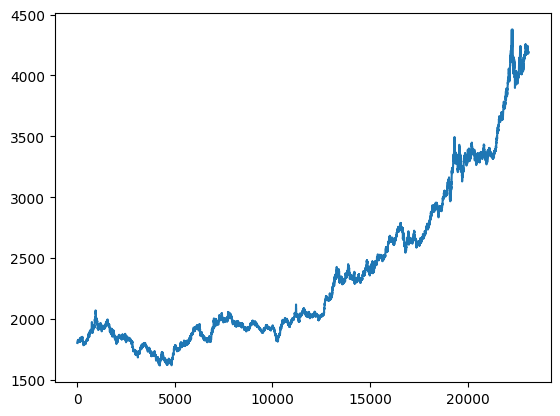

In [69]:
#Visual check

data['close'].plot()

In [90]:
#Features and target
X = data.drop(columns=['close','Up Trend','Down Trend','Unnamed: 16'])
X['time'] = pd.to_datetime(X['time'])
X['unix_timestamp'] = X['time'].apply(lambda x: x.timestamp())
y = data['close']

X.shape, y.shape


/var/folders/cv/0c80h97d4ksflxwnpnhp9g2m0000gn/T/ipykernel_77034/235817639.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  X['time'] = pd.to_datetime(X['time'])


((23112, 14), (23112,))

In [91]:
#data check
X.dtypes.value_counts()

float64           13
datetime64[ns]     1
Name: count, dtype: int64

In [ ]:
y.dtype

dtype('float64')

In [104]:
y.head(5)

0    1801.18
1    1802.70
2    1804.85
3    1805.18
4    1805.91
Name: close, dtype: float64

In [93]:
X.head(5)

,time,open,high,low,Basis,Upper,Lower,KAMA,RSI,Bollinger Bands %b,Bollinger BandWidth,Highest Expansion,Lowest Contraction,unix_timestamp
0,2022-01-11 00:00:00,1801.23,1802.85,1800.03,1796.565,1802.85,1790.28,1795.256156,65.669045,0.831694,0.803134,2.519134,0.332677,1.641859e+09
1,2022-01-11 01:00:00,1801.16,1804.61,1801.15,1797.445,1804.61,1790.28,1795.536505,69.806836,0.888896,0.826182,2.519134,0.332677,1.641863e+09
2,2022-01-11 02:00:00,1802.68,1805.91,1802.00,1798.095,1805.91,1790.28,1795.896520,74.665739,0.963492,0.876434,2.519134,0.332677,1.641866e+09
3,2022-01-11 03:00:00,1804.83,1806.31,1804.21,1798.295,1806.31,1790.28,1796.250762,75.350694,0.925586,0.917716,2.519134,0.332677,1.641870e+09
4,2022-01-11 04:00:00,1805.18,1807.73,1804.99,1799.005,1807.73,1790.28,1796.635508,76.904655,0.915073,0.952947,2.519134,0.332677,1.641874e+09


In [95]:
#preprocessing

preproc_numerical_baseline = make_pipeline(
    SimpleImputer(),
    RobustScaler()
)

preproc_baseline = make_column_transformer(
    (preproc_numerical_baseline, ['open', 'high', 'low', 'Basis', 'Upper', 'Lower', 'KAMA', 'RSI', 'Bollinger Bands %b', 'Bollinger BandWidth', 'Highest Expansion', 'Lowest Contraction','unix_timestamp']),
)

preproc_baseline

ColumnTransformer(transformers=[('pipeline',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('robustscaler',
                                                  RobustScaler())]),
                                 ['open', 'high', 'low', 'Basis', 'Upper',
                                  'Lower', 'KAMA', 'RSI', 'Bollinger Bands %b',
                                  'Bollinger BandWidth', 'Highest Expansion',
                                  'Lowest Contraction', 'unix_timestamp'])])

In [96]:
# Create eval test just for early-stopping purposes (XGBOOST and Deep Learning)
train_size = int(0.8 * len(X))
X_train, X_eval = X[:train_size], X[train_size:]
y_train, y_eval = y[:train_size], y[train_size:]


In [97]:
# Preprocess eval data
preproc_baseline.fit(X_train, y_train)
X_train_preproc = preproc_baseline.transform(X_train)
X_eval_preproc = preproc_baseline.transform(X_eval)

In [122]:
X_train_preproc

array([[-0.33564677, -0.33613082, -0.33426144, ...,  0.04680314,
        -0.23891313, -0.99375681],
       [-0.33579093, -0.33251054, -0.33195149, ...,  0.04680314,
        -0.23891313, -0.99368421],
       [-0.33266058, -0.32983647, -0.33019841, ...,  0.04680314,
        -0.23891313, -0.99361162],
       ...,
       [ 1.89647219,  1.90461792,  1.89547498, ..., -0.27082227,
         1.25863057,  0.99869328],
       [ 1.90470993,  1.90513216,  1.86802376, ..., -0.27082227,
         1.25863057,  0.99876588],
       [ 1.87023498,  1.88487092,  1.87363363, ..., -0.27082227,
         1.25863057,  0.99883848]])

In [112]:
# Instantiate model
model_xgb = XGBRegressor(max_depth=4,
                         n_estimators=1500,
                         learning_rate=0.1
                         )

In [113]:
# Train the model on a rolling window of data
for i in range(len(X_train_preproc) - 528):  # Use a 30-days rolling window
    X_window = X_train_preproc[i:i+528]
    y_window = y_train[i:i+528]
    model_xgb.fit(X_window, y_window)
    y_pred = model_xgb.predict(X_eval_preproc)
    mae = mean_absolute_error(y_eval, y_pred)
    print(f"MAE: {mae:.2f}")

MAE: 1654.92
MAE: 1654.44
MAE: 1654.88
MAE: 1654.59
MAE: 1655.34
MAE: 1654.68
MAE: 1654.77
MAE: 1653.88
MAE: 1653.87
MAE: 1654.54
MAE: 1654.83
MAE: 1654.96
MAE: 1653.78
MAE: 1654.05
MAE: 1655.65
MAE: 1654.57
MAE: 1654.38
MAE: 1654.23
MAE: 1654.45
MAE: 1651.72
MAE: 1649.43
MAE: 1646.83
MAE: 1645.75
MAE: 1645.82
MAE: 1645.75
MAE: 1646.24
MAE: 1646.02
MAE: 1645.99
MAE: 1646.22
MAE: 1646.50
MAE: 1646.41
MAE: 1646.17
MAE: 1646.25
MAE: 1646.94
MAE: 1647.30
MAE: 1646.40
MAE: 1646.61
MAE: 1645.64
MAE: 1639.33
MAE: 1638.61
MAE: 1641.32
MAE: 1640.93
MAE: 1638.74
MAE: 1638.41
MAE: 1638.38
MAE: 1637.42
MAE: 1636.93
MAE: 1636.88
MAE: 1636.63
MAE: 1631.44
MAE: 1628.86
MAE: 1629.91
MAE: 1628.98
MAE: 1628.66
MAE: 1628.25
MAE: 1627.64
MAE: 1627.35
MAE: 1627.35
MAE: 1627.20
MAE: 1627.81
MAE: 1627.46
MAE: 1627.72
MAE: 1627.26
MAE: 1627.66
MAE: 1627.50
MAE: 1627.68
MAE: 1627.40
MAE: 1628.03
MAE: 1627.71
MAE: 1628.65
MAE: 1627.65
MAE: 1627.64
MAE: 1627.64
MAE: 1627.42
MAE: 1627.32
MAE: 1627.53
MAE: 1627.64

KeyboardInterrupt: 

In [118]:
model_xgb2 = XGBRegressor(
    max_depth=5,
    learning_rate=0.05,
    n_estimators=500,
    gamma=0.1,
    subsample=0.8,
    colsample_bytree=0.8
)

In [119]:
# Train the model on a rolling window of data. XGB2 model - specific parameters
for i in range(len(X_train_preproc) - 528):  # Use a 30-days rolling window
    X_window = X_train_preproc[i:i+528]
    y_window = y_train[i:i+528]
    model_xgb2.fit(X_window, y_window)
    y_pred = model_xgb.predict(X_eval_preproc)
    mae = mean_absolute_error(y_eval, y_pred)
    print(f"MAE: {mae:.2f}")

MAE: 1535.01
MAE: 1535.01
MAE: 1535.01
MAE: 1535.01
MAE: 1535.01
MAE: 1535.01
MAE: 1535.01
MAE: 1535.01
MAE: 1535.01
MAE: 1535.01
MAE: 1535.01
MAE: 1535.01
MAE: 1535.01
MAE: 1535.01


KeyboardInterrupt: 

In [103]:
# Create a linear regression model
model_lr = LinearRegression()

# Train the model
model_lr.fit(X_train_preproc, y_train)

# Make predictions
y_pred_lr = model_lr.predict(X_eval_preproc)

# Calculate MAE
mae_lr = mean_absolute_error(y_eval, y_pred_lr)
print(f"MAE (Linear Regression): {mae_lr:.2f}")

MAE (Linear Regression): 2.69


In [125]:
pd.DataFrame(y_pred_lr)

,0
0,2877.632447
1,2882.498785
2,2887.071474
3,2881.300499
4,2875.870481
...,...
4618,4189.394133
4619,4182.379078
4620,4177.947385
4621,4181.922291


In [126]:
y_eval.head

<bound method NDFrame.head of 18489    2877.41
18490    2883.25
18491    2887.37
18492    2879.29
18493    2873.96
          ...   
23107    4186.93
23108    4179.83
23109    4182.07
23110    4182.43
23111    4191.42
Name: close, Length: 4623, dtype: float64>

##Simplest Baseline for reference

In [183]:
y_pred_baseline = y_eval.shift(1).dropna()
y_true = y_eval[1:]
mae_baseline = mean_absolute_error(y_true, y_pred_baseline)
print(f"MAE (shift): {mae_baseline:.2f}")

MAE (shift): 6.10


In [142]:
# SARIMAX test

import pmdarima as pm
sarimax = pm.auto_arima(y_train, exogenous=X_train_preproc,
                           start_p=1, start_d=1,start_q=1,
                           test='adf',
                           max_p=3, max_d=2, max_q=3, m=1,
                           start_P=0, seasonal=True,
                           D=None, trace=True,
                           suppress_warnings=True,
                           stepwise=False, n_jobs=-1,
                           random=True, random_state=42)

 ARIMA(0,1,0)(0,0,0)[1] intercept   : AIC=102331.203, Time=0.14 sec
 ARIMA(0,1,1)(0,0,0)[1] intercept   : AIC=102332.599, Time=0.28 sec
 ARIMA(1,1,0)(0,0,0)[1] intercept   : AIC=102332.589, Time=0.26 sec
 ARIMA(2,1,0)(0,0,0)[1] intercept   : AIC=102333.214, Time=0.33 sec
 ARIMA(1,1,1)(0,0,0)[1] intercept   : AIC=102334.594, Time=0.39 sec
 ARIMA(0,1,2)(0,0,0)[1] intercept   : AIC=102333.287, Time=0.44 sec
 ARIMA(3,1,2)(0,0,0)[1] intercept   : AIC=102331.453, Time=1.41 sec
 ARIMA(2,1,1)(0,0,0)[1] intercept   : AIC=102327.491, Time=1.65 sec
 ARIMA(3,1,1)(0,0,0)[1] intercept   : AIC=102329.279, Time=1.76 sec
 ARIMA(2,1,3)(0,0,0)[1] intercept   : AIC=102331.395, Time=2.05 sec

Best model:  ARIMA(2,1,1)(0,0,0)[1] intercept
Total fit time: 2.347 seconds


In [141]:
# Prediction
y_pred_sar = sarimax.predict(n_periods=len(y_eval), exogenous=X_eval_preproc)

# Calculate MAE

mae_sarimax = mean_absolute_error(y_eval, y_pred_sar)

print(f"MAE: {mae_sarimax:.2f}")

MAE: 497.32


In [144]:
y_pred_sar.head(10)

18489    2872.171369
18490    2872.391142
18491    2872.306478
18492    2872.489784
18493    2872.437233
18494    2872.592273
18495    2872.564600
18496    2872.697745
18497    2872.689343
18498    2872.805525
dtype: float64

In [177]:
import yfinance as yf

ticker = 'GC=F'
start_date = '1980-01-01'
end_date = '2025-12-01'
interval = '1d'

df_yahoo = yf.download(ticker, start=start_date, end=end_date, interval=interval)
gold_yahoo = pd.DataFrame(df_yahoo)
df_yahoo.to_csv('gold_price_5y_1h.csv')

/var/folders/cv/0c80h97d4ksflxwnpnhp9g2m0000gn/T/ipykernel_77034/4115540115.py:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df_yahoo = yf.download(ticker, start=start_date, end=end_date, interval=interval)
[*********************100%***********************]  1 of 1 completed


In [178]:
gold_yahoo.head()

Price,Close,High,Low,Open,Volume
Ticker,GC=F,GC=F,GC=F,GC=F,GC=F
Date,,,,,
2000-08-30,273.899994,273.899994,273.899994,273.899994,0
2000-08-31,278.299988,278.299988,274.799988,274.799988,0
2000-09-01,277.000000,277.000000,277.000000,277.000000,0
2000-09-05,275.799988,275.799988,275.799988,275.799988,2
2000-09-06,274.200012,274.200012,274.200012,274.200012,0


In [179]:
gold_yahoo.tail()

Price,Close,High,Low,Open,Volume
Ticker,GC=F,GC=F,GC=F,GC=F,GC=F
Date,,,,,
2025-11-21,4076.699951,4085.199951,4031.800049,4031.800049,171
2025-11-24,4091.899902,4091.899902,4060.500000,4060.500000,591
2025-11-25,4139.200195,4139.200195,4139.200195,4139.200195,132704
2025-11-26,4165.200195,4171.000000,4127.500000,4128.600098,25088
2025-11-28,4218.299805,4223.899902,4140.000000,4163.399902,3615


In [173]:
gold_yahoo.shape

(6336, 5)